In [1]:
from POSEIDON.core import create_star, create_planet
from POSEIDON.constants import R_J, R_Sun

R_s = 0.42*R_Sun
T_s = 3600
log_g_s = 4.85
Met_s = -0.5

star = create_star(R_s, T_s, log_g_s, Met_s)

planet_name = 'TOI-1266 c'
R_p = 0.139*R_J
T_eq = 345.87
g_p = 8.87769

planet = create_planet(planet_name, R_p, gravity=g_p, T_eq=T_eq)

/home/swaroop/anaconda3/envs/poseidon/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /home/swaroop/sample/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/swaroop/POSEIDON/POSEIDON/absorption.py:1466: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def store_Rayleigh_eta_LBL(wl_model, chemical_species):


In [2]:
from POSEIDON.core import define_model
import numpy as np

model_name = '95%CO2 5% H2O'

bulk_species = ['CO2']
param_species = ['H2O']

# Create the model object
model = define_model(model_name, bulk_species, param_species,
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

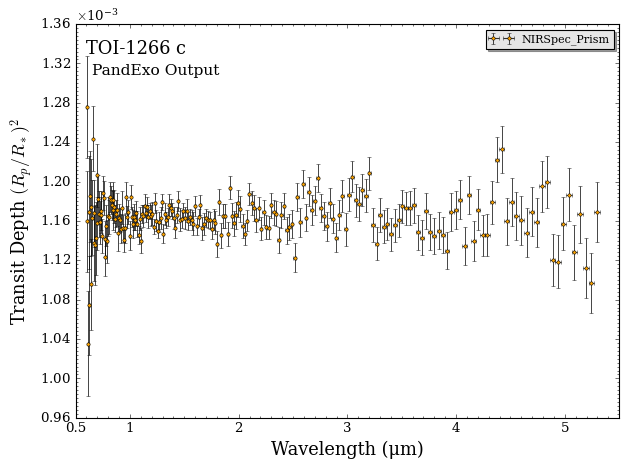

In [3]:
from POSEIDON.core import load_data, wl_grid_constant_R
from POSEIDON.visuals import plot_data

wl_min = 0.5
wl_max = 5.5

R = 10000

wl = wl_grid_constant_R(wl_min, wl_max, R)

data_dir = './data/' + planet_name

datasets_new = ['TOI-1266 c_SYNTHETIC_JWST_NIRSpec_Prism_95%CO2 5% H2O_N_trans_10.dat']
#This datasetsnew is obtained from function generate synthetic file

instruments = ['JWST_NIRSpec_Prism']

data_new = load_data(data_dir, datasets_new, instruments, wl)

fig_data = plot_data(data_new, planet_name, wl_min, wl_max, wl_axis='linear',
                     data_labels = ['NIRSpec_Prism'], 
                     plt_label = 'PandExo Output')

In [62]:
from POSEIDON.core import set_priors

prior_types = {}
prior_ranges = {}

prior_types['T'] = 'uniform'
prior_types['R_p_ref'] = 'uniform'
prior_types['log_X'] = 'uniform'

prior_ranges['T'] = [100, 1000]
prior_ranges['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges['log_X'] = [-12,-1] 

priors = set_priors(planet, star, model, data_new, prior_types, prior_ranges)

In [63]:
from POSEIDON.core import wl_grid_constant_R, read_opacities

#***Reading Opacities***#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100     # Same as prior range for T
T_fine_max = 1000    # Same as prior range for T
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step),
                       log_P_fine_step)

# Pre-interpolate the opacities (note: model wavelength range was initialised in cell above)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
CO2-CO2 done
CO2 done
H2O done
Opacity pre-interpolation complete.


In [6]:
# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1         # 1 bar
R_p_ref = R_p         # Radius at reference pressure

In [22]:
from POSEIDON.retrieval import run_retrieval

run_retrieval(planet, star, model, opac, data_new, priors, wl, P, P_ref, 
             R=R, spectrum_type='transmission', sampling_algorithm=
              'MultiNest', N_live = 400, verbose=True, resume = False)

POSEIDON now running '95%CO2 5% H2O'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.993377
Replacements:                                450
Total Samples:                               453
Nested Sampling ln(Z):             -24926.474597
Acceptance Rate:                        0.984252
Replacements:                                500
Total Samples:                               508
Nested Sampling ln(Z):             -20226.747928
Acceptance Rate:                        0.951557
Replacements:                                550
Total Samples:                               578
Nested Sampling ln(Z):             -15730.447470
Acceptance Rate:                        0.928793
Replac

In [23]:
#pwd

'/home/swaroop/nb/TOI-1266 c/New'

Generating corner plot ...


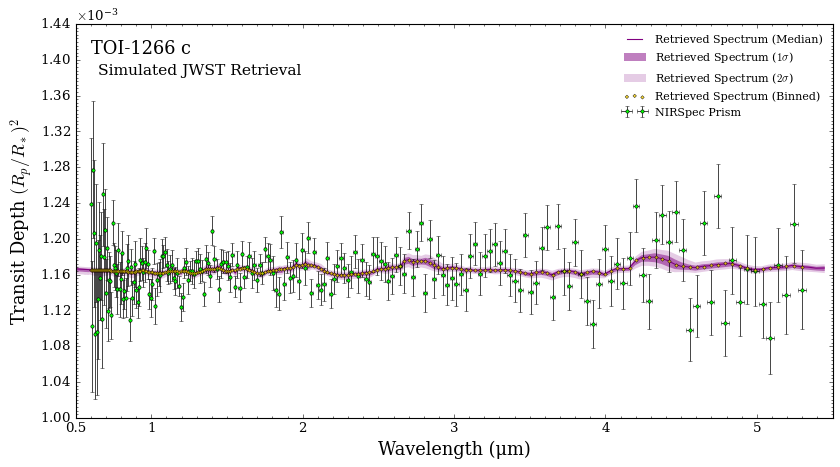

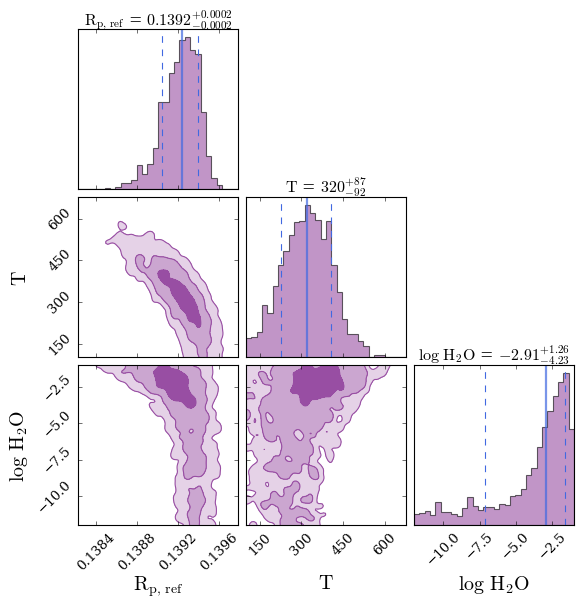

In [8]:
from POSEIDON.utility import read_retrieved_spectrum, plot_collection
from POSEIDON.visuals import plot_spectra_retrieved
from POSEIDON.corner import generate_cornerplot

wl, spec_low2, spec_low1, spec_median, spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name)

spectra_median = plot_collection(spec_median, wl, collection = [])
spectra_low1 = plot_collection(spec_low1, wl, collection = [])
spectra_low2 = plot_collection(spec_low2, wl, collection = [])
spectra_high1 = plot_collection(spec_high1, wl, collection = [])
spectra_high2 = plot_collection(spec_high2, wl, collection = [])

fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1,
                                  spectra_high1, spectra_high2, planet_name,
                                  data_new, R_to_bin = 100,
                                  data_labels = ['NIRSpec Prism'],
                                  figure_shape = 'wide', wl_axis = 'linear',
                                  plt_label = 'Simulated JWST Retrieval')

fig_corner = generate_cornerplot(planet, model)#, true_vals = [R_p/R_J, PT_params[0],
                                                #             log_X_params[0], log_X_params[1]])

In [24]:
#***** Define new model *****#
#####MODEL-2#########
model_name_2 = '95%CO2 5%H2'

bulk_species_2 = ['CO2']
param_species_2 = ['H2']  

# Create the model object
model_2 = define_model(model_name_2, bulk_species_2, param_species_2,
                       PT_profile = 'isotherm', cloud_model = 'cloud-free')

#####MODEL-3#########
model_name_3 = '95%H2O 5%H2'

bulk_species_3 = ['H2O']
param_species_3 = ['H2']  

# Create the model object
model_3 = define_model(model_name_3, bulk_species_3, param_species_3,
                       PT_profile = 'isotherm', cloud_model = 'cloud-free')

#####MODEL-4#########
model_name_4 = '89%H2O 10%CO2 1%H2'

bulk_species_4 = ['H2O']
param_species_4 = ['CO2','H2'] 

# Create the model object
model_4 = define_model(model_name_4, bulk_species_4, param_species_4,
                       PT_profile = 'isotherm', cloud_model = 'cloud-free')

#####MODEL-5#########
model_name_5 = '96.5%CO2 3.5%N2'

bulk_species_5 = ['CO2']
param_species_5 = ['N2']  

# Create the model object
model_5 = define_model(model_name_5, bulk_species_5, param_species_5,
                       PT_profile = 'isotherm', cloud_model = 'cloud-free')

#***** Read opacity data *****#

# Pre-interpolate the opacities
opac_2 = read_opacities(model_2, wl, opacity_treatment, T_fine, log_P_fine)
opac_3 = read_opacities(model_3, wl, opacity_treatment, T_fine, log_P_fine)
opac_4 = read_opacities(model_4, wl, opacity_treatment, T_fine, log_P_fine)
opac_5 = read_opacities(model_5, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
CO2-H2 done
CO2-CO2 done
CO2 done
Opacity pre-interpolation complete.
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2O done
Opacity pre-interpolation complete.
Reading in cross sections in opacity sampling mode...
H2-H2 done
CO2-H2 done
CO2-CO2 done
H2O done
CO2 done
Opacity pre-interpolation complete.
Reading in cross sections in opacity sampling mode...
CO2-CO2 done
N2-N2 done
CO2 done
N2 done
Opacity pre-interpolation complete.


In [39]:
# import os
# os.chdir("/home/swaroop/nb/TOI-1266 c/New/")

In [44]:
#pwd

'/home/swaroop/nb/TOI-1266 c/New'

In [31]:
#***** Set priors for new retrieval *****#

# Initialise prior type dictionary
prior_types_2 = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types_2['T'] = 'uniform'
prior_types_2['R_p_ref'] = 'uniform'
prior_types_2['log_X'] = 'uniform'    # 'log_X' sets the same prior for all mixing ratios

# Initialise prior range dictionary
prior_ranges_2 = {}

# Specify prior ranges for each free parameter
prior_ranges_2['T'] = [100, 1000]
prior_ranges_2['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges_2['log_X'] = [-12, -1]   # 'log_X' sets the same prior for all mixing ratios

# Create prior object for retrieval
priors_2 = set_priors(planet, star, model_2, data_new, prior_types_2, prior_ranges_2)

In [32]:
#***** Run atmospheric retrieval *****#

run_retrieval(planet, star, model_2, opac_2, data_new, priors_2, wl, P, P_ref, 
             R=R, spectrum_type='transmission', sampling_algorithm=
              'MultiNest', N_live = 400, verbose=True, resume = False)

POSEIDON now running '95%CO2 5%H2'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.991189
Replacements:                                450
Total Samples:                               454
Nested Sampling ln(Z):             -25164.779156
Acceptance Rate:                        0.963391
Replacements:                                500
Total Samples:                               519
Nested Sampling ln(Z):             -20398.292162
Acceptance Rate:                        0.940171
Replacements:                                550
Total Samples:                               585
Nested Sampling ln(Z):             -14448.557722
Acceptance Rate:                        0.906344
Replacem

In [ ]:
#***** Set priors for new retrieval *****#

# Initialise prior type dictionary
prior_types_3 = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types_3['T'] = 'uniform'
prior_types_3['R_p_ref'] = 'uniform'
prior_types_3['log_X'] = 'uniform'    # 'log_X' sets the same prior for all mixing ratios

# Initialise prior range dictionary
prior_ranges_3 = {}

# Specify prior ranges for each free parameter
prior_ranges_3['T'] = [100, 1000]
prior_ranges_3['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges_3['log_X'] = [-12, -1]   # 'log_X' sets the same prior for all mixing ratios

# Create prior object for retrieval
priors_3 = set_priors(planet, star, model_3, data_new, prior_types_3, prior_ranges_3)

In [33]:
run_retrieval(planet, star, model_3, opac_3, data_new, priors_3, wl, P, P_ref, R = R,
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest',
              N_live = 400, verbose = True)

POSEIDON now running '95%H2O 5%H2'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.989011
Replacements:                                450
Total Samples:                               455
Nested Sampling ln(Z):             -27074.615182
Acceptance Rate:                        0.963391
Replacements:                                500
Total Samples:                               519
Nested Sampling ln(Z):             -18063.256944
Acceptance Rate:                        0.930626
Replacements:                                550
Total Samples:                               591
Nested Sampling ln(Z):             -13832.360365
Acceptance Rate:                        0.891530
Replacem

In [41]:
#***** Set priors for new retrieval *****#

# Initialise prior type dictionary
prior_types_4 = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types_4['T'] = 'uniform'
prior_types_4['R_p_ref'] = 'uniform'
prior_types_4['log_X'] = 'uniform'    # 'log_X' sets the same prior for all mixing ratios

# Initialise prior range dictionary
prior_ranges_4 = {}

# Specify prior ranges for each free parameter
prior_ranges_4['T'] = [100, 1000]
prior_ranges_4['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges_4['log_X'] = [-12, -1]   # 'log_X' sets the same prior for all mixing ratios

# Create prior object for retrieval
priors_4 = set_priors(planet, star, model_4, data_new, prior_types_4, prior_ranges_4)

In [42]:
run_retrieval(planet, star, model_4, opac_4, data_new, priors_4, wl, P, P_ref, R = R,
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest',
              N_live = 400, verbose = True)

POSEIDON now running '89%H2O 10%CO2 1%H2'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.989011
Replacements:                                450
Total Samples:                               455
Nested Sampling ln(Z):             -31912.648849
Acceptance Rate:                        0.965251
Replacements:                                500
Total Samples:                               518
Nested Sampling ln(Z):             -21385.741115
Acceptance Rate:                        0.932203
Replacements:                                550
Total Samples:                               590
Nested Sampling ln(Z):             -15959.105267
Acceptance Rate:                        0.894188
R

In [45]:
#***** Set priors for new retrieval *****#

# Initialise prior type dictionary
prior_types_5 = {}

# Specify whether priors are linear, Gaussian, etc.
prior_types_5['T'] = 'uniform'
prior_types_5['R_p_ref'] = 'uniform'
prior_types_5['log_X'] = 'uniform'    # 'log_X' sets the same prior for all mixing ratios

# Initialise prior range dictionary
prior_ranges_5 = {}

# Specify prior ranges for each free parameter
prior_ranges_5['T'] = [100, 1000]
prior_ranges_5['R_p_ref'] = [0.85*R_p, 1.15*R_p]
prior_ranges_5['log_X'] = [-12, -1]   # 'log_X' sets the same prior for all mixing ratios

# Create prior object for retrieval
priors_5 = set_priors(planet, star, model_5, data_new, prior_types_5, prior_ranges_5)

In [46]:
run_retrieval(planet, star, model_5, opac_5, data_new, priors_5, wl, P, P_ref, R = R,
              spectrum_type = 'transmission', sampling_algorithm = 'MultiNest',
              N_live = 400, verbose = True)

POSEIDON now running '96.5%CO2 3.5%N2'
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    3
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        0.991189
Replacements:                                450
Total Samples:                               454
Nested Sampling ln(Z):             -24989.082355
Acceptance Rate:                        0.972763
Replacements:                                500
Total Samples:                               514
Nested Sampling ln(Z):             -19539.009013
Acceptance Rate:                        0.945017
Replacements:                                550
Total Samples:                               582
Nested Sampling ln(Z):             -13117.484730
Acceptance Rate:                        0.909091
Repl

In [52]:
from POSEIDON.retrieval import Bayesian_model_comparison

model_ref = model
model_steamh2 = model_3 
model_co2h2 = model_2
model_venus = model_5

Bayesian_model_comparison(planet_name, model_ref, model_steamh2)

Bayesian evidences:

Model 95%CO2 5% H2O: ln Z = 2000.91 +/- 0.13
Model 95%H2O 5%H2: ln Z = 1995.67 +/- 0.13

Bayes factor:

B = 1.89e+02
ln B = 5.24

'Equivalent' detection significance:

3.7 σ



In [58]:
Bayesian_model_comparison(planet_name, model_co2h2, model_ref)

Bayesian evidences:

Model 95%CO2 5%H2: ln Z = 1999.83 +/- 0.13
Model 95%CO2 5% H2O: ln Z = 2001.30 +/- 0.12

Bayes factor:

B = 2.30e-01
ln B = -1.47

No detection of the reference model, model 95%CO2 5% H2O is preferred.



In [54]:
Bayesian_model_comparison(planet_name, model_ref, model_venus)

Bayesian evidences:

Model 95%CO2 5% H2O: ln Z = 2000.91 +/- 0.13
Model 96.5%CO2 3.5%N2: ln Z = 2000.28 +/- 0.12

Bayes factor:

B = 1.86e+00
ln B = 0.62

'Equivalent' detection significance:

1.8 σ



In [57]:
Bayesian_model_comparison(planet_name, model_3, model_4)

Bayesian evidences:

Model 95%H2O 5%H2: ln Z = 1995.05 +/- 0.13
Model 89%H2O 10%CO2 1%H2: ln Z = 1996.69 +/- 0.13

Bayes factor:

B = 1.93e-01
ln B = -1.64

No detection of the reference model, model 89%H2O 10%CO2 1%H2 is preferred.



In [ ]:
# from POSEIDON.utility import read_retrieved_spectrum, plot_collection
# from POSEIDON.visuals import plot_spectra_retrieved
# from POSEIDON.corner import generate_cornerplot

# wl, spec_low2, spec_low1, spec_median, spec_high1, spec_high2 = read_retrieved_spectrum(planet_name, model_name_2)

# spectra_median = plot_collection(spec_median, wl, collection = spectra_median)
# spectra_low1 = plot_collection(spec_low1, wl, collection = spectra_low1)
# spectra_low2 = plot_collection(spec_low2, wl, collection = spectra_low2)
# spectra_high1 = plot_collection(spec_high1, wl, collection = spectra_high1)
# spectra_high2 = plot_collection(spec_high2, wl, collection = spectra_high2)

# fig_spec = plot_spectra_retrieved(spectra_median, spectra_low2, spectra_low1,
#                                   spectra_high1, spectra_high2, planet_name,
#                                   data_new, R_to_bin = 100, spectra_labels=['Reference', 'CO2-H2'],
#                                   data_labels = ['NIRSpec Prism'],
#                                   figure_shape = 'wide', wl_axis = 'linear',
#                                   plt_label = 'Simulated JWST Retrieval')

# fig_corner = generate_cornerplot(planet, model)